### Step 1: Exploring and formatting the data

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

lng_df = pd.read_csv('lng.csv')
lng_df['Date'] = pd.to_datetime(lng_df['Date'], format='%Y-%m-%d')
lng_df.set_index(['Date'],inplace=True)

smlv_df = pd.read_csv('smlv.csv')
smlv_df['Date'] = pd.to_datetime(smlv_df['Date'], format='%Y-%m-%d')
smlv_df.set_index(['Date'],inplace=True)

spy_df = pd.read_csv('spy.csv')
spy_df['Date'] = pd.to_datetime(spy_df['Date'], format='%Y-%m-%d')
spy_df.set_index(['Date'],inplace=True)

#join the three stock dataframes together
full_df = pd.concat([lng_df, spy_df, smlv_df], axis=1).dropna()

#resample the full dataframe to monthly timeframe
monthly_df = full_df.resample('BMS').first()

#daily returns of stocks
returns_daily = full_df.pct_change()

#monthly returns of stocks
returns_monthly = monthly_df.pct_change().dropna()
print(full_df.tail())

              LNG     SPY     SMLV
Date                              
2018-05-24  61.67  272.80  92.9340
2018-05-25  62.16  272.15  93.0938
2018-05-29  63.31  269.02  93.1900
2018-05-30  66.98  272.61  94.3621
2018-05-31  66.62  270.94  93.6480


### Step 2: Calculating covariances for volatility

In [43]:
covariances = {}
rtd_index = returns_daily.index

for i in returns_monthly.index:
    #create mask to get daily returns which are in the current month and year in each iteration
    mask = (rtd_index.month == i.month) & (rtd_index.year == i.year)
    covariances[i] = returns_daily[mask].cov()

print(covariances[i])

           LNG       SPY      SMLV
LNG   0.000376  0.000057  0.000060
SPY   0.000057  0.000043  0.000023
SMLV  0.000060  0.000023  0.000025


### Step 3: Calculating potfolios using risk and volatility

In [44]:
#Generating 1000 best porfolios for each month

portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}

#Evaluating portfolio performance at each month
for date in sorted(covariances.keys()):
    cov = covariances[date]
    for portfolio in range(1000):
        weights = np.random.random(3)
        weights /= np.sum(weights) # /= divides weights by their sum to normalize
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)
        
print(portfolio_weights[date][0])


[0.01673696 0.47382005 0.50944299]


Plotting the results of the Modern Portfolio Theory (MPT) analysis for the latest date available in the data. This is a plot of volatility vs returns. This can help visualize risk-return possibilities for portfolios. The upper left region gives the best options (highest returns for a given risk).

2018-05-01 00:00:00


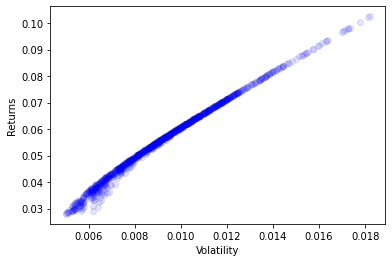

In [45]:
#Getting latest date of available data
date = sorted(covariances.keys())[-1]  
print(date)

plt.scatter(x=portfolio_volatility[date], y=portfolio_returns[date], color='blue', alpha=0.1)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

### Step 4: Using the Sharpe ratio for best portfolio selection

In [46]:
sharpe_ratio, max_sharpe_idxs = {}, {}

for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):
        sharpe_ratio.setdefault(date, []).append(ret/portfolio_volatility[date][i])
        
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])
    
print(portfolio_returns[date][max_sharpe_idxs[date]])

0.044668778297846226


In [47]:
#Feature as price movement EWMA (exponentially weighted moving average)
#EWMA means recent prices get higher weights

ewma_daily = returns_daily.ewm(span=30).mean()
ewma_monthly = ewma_daily.resample('BMS').first()
ewma_monthly = ewma_monthly.shift(1).dropna()

print(ewma_monthly.iloc[-1])

LNG    -0.000751
SPY    -0.002635
SMLV   -0.001181
Name: 2018-05-01 00:00:00, dtype: float64


In [48]:
targets, features = [], []

for date, ewma in ewma_monthly.iterrows():
    best_idx = max_sharpe_idxs[date]
    targets.append(portfolio_weights[date][best_idx])
    features.append(ewma)

targets = np.array(targets)
features = np.array(features)

print(targets[-5:])

[[0.85267091 0.13980292 0.00752616]
 [0.31708672 0.68113144 0.00178184]
 [0.03729973 0.95292704 0.00977323]
 [0.38888286 0.00149149 0.60962565]
 [0.20856605 0.19812271 0.59331124]]


Plotting the MPT results again but adding an orange marker for the best portfolio according to the Sharpe ratio.

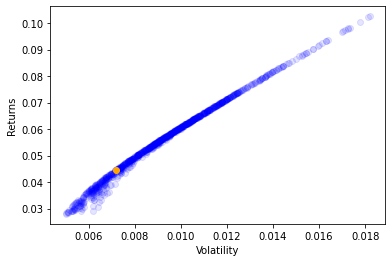

In [49]:
#Getting the latest date's returns and volatility

date = sorted(covariances.keys())[-1]
current_returns = portfolio_returns[date]
current_volatility = portfolio_volatility[date]

plt.scatter(x=current_volatility, y=current_returns, alpha=0.1, color='blue')
best_idx = max_sharpe_idxs[date]


plt.scatter(x=current_volatility[best_idx], y=current_returns[best_idx], marker='o', color='orange')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

### Step 5: Fitting a Machine Learning model

The outcomes are ideal portfolio weights and the features are the Exponentially-Weighted Moving Averages

Creating train and testing sets

In [58]:
from sklearn.ensemble import RandomForestRegressor

# Making train and test features
train_size = int(0.85 * features.shape[0])

train_features = features[:train_size]
test_features = features[train_size:]

train_targets = targets[:train_size]
test_targets = targets[train_size:]

# Fitting the model and check scores on train and test
rfr = RandomForestRegressor(n_estimators=300, random_state=42)
rfr.fit(train_features, train_targets)
print(rfr.score(train_features, train_targets))

0.8199609208953796


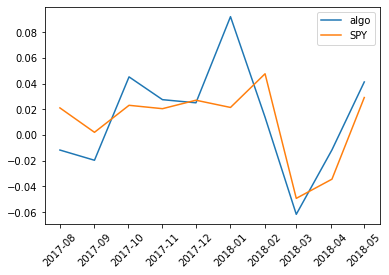

In [30]:
# Getting predictions from model on train and test
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Calculating and plot returns from our RF predictions and the SPY returns
test_returns = np.sum(returns_monthly.iloc[train_size:] * test_predictions, axis=1)
plt.plot(test_returns, label='algo')
plt.plot(returns_monthly['SPY'].iloc[train_size:], label='SPY')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Evaluating returns

Compare returns from our portfolio predictions to those obtained by just investing in SPY using an initial amount of 1000$

In [31]:
# Calculating the effect of our portfolio selection on a hypothetical $1k investment
cash = 1000
algo_cash, spy_cash = [cash], [cash] # set equal starting cash amounts
for r in test_returns:
    cash *= 1 + r
    algo_cash.append(cash)

# Calculating performance for SPY
cash = 1000
for r in returns_monthly['SPY'].iloc[train_size:]:
    cash *= 1 + r
    spy_cash.append(cash)

print('algo returns:', (algo_cash[-1] - algo_cash[0]) / algo_cash[0])
print('SPY returns:', (spy_cash[-1] - spy_cash[0]) / spy_cash[0])

algo returns: 0.14052633589182484
SPY returns: 0.10942393961703784


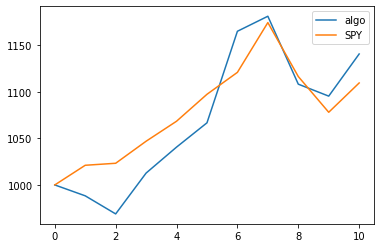

In [32]:
#Plotting the returns

plt.plot(algo_cash, label='algo')
plt.plot(spy_cash, label='SPY')
plt.legend()
plt.show()

Exporting an instance of the model

In [33]:
from sklearn.tree import export_graphviz
from IPython.display import Image

#Extract single tree
#Predictions flatten out after the 100th tree
estimator = rfr.estimators_[150]

# Export as dot file
export_graphviz(estimator, 
                out_file='tree.dot',
                feature_names=['LNG', 'SPY', 'SMLV'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

Image(filename = 'tree.png')